In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from itertools import cycle, islice
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [115]:
train_file_name = 'drugsComTrain_raw.csv'
test_file_name = 'drugsComTest_raw.csv'
file_path = './data/'

df_test = pd.read_csv(file_path+test_file_name)
df_train = pd.read_csv(file_path+train_file_name)

In [4]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


## Top five conditions

In [23]:
df_train['condition'].value_counts().sort_values(ascending=False)[0:5]

Birth Control    28788
Depression        9069
Pain              6145
Anxiety           5904
Acne              5588
Name: condition, dtype: int64

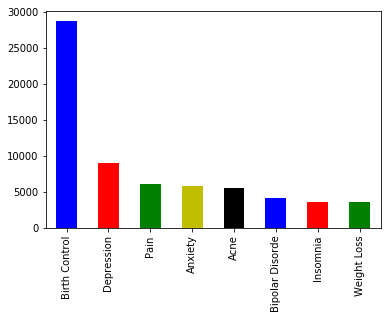

In [40]:
bar_data = df_train['condition'].value_counts().sort_values(ascending=False)[0:8]
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(bar_data)))
bar_data.plot.bar(color=my_colors,stacked=True)

Text(0,0.5,'Useful Count')

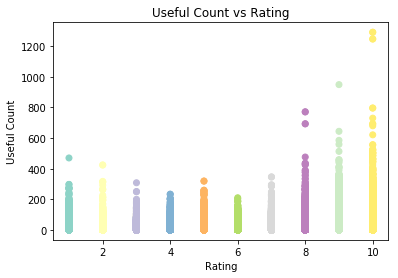

In [47]:
plt.scatter(df_train['rating'], df_train['usefulCount'], c=df_train['rating'].values\
            , cmap='Set3')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')

In [52]:
vader_analyzer = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = vader_analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [53]:
sentiments = []
for i in df_train.review:
    sentiments.append(vader_analyzer.polarity_scores(i))
    
sentiments = np.asarray(sentiments)

In [116]:
print(sentiments[2])
df_train.review[2]
df_train.rating[2]

{'neg': 0.038, 'neu': 0.884, 'pos': 0.078, 'compound': 0.7645}


5

In [84]:
# Creates TF-IDF vectorizer and transforms the corpus
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train.review)

# transforms test reviews to above vectorized format
X_test = vectorizer.transform(df_test.review)

In [95]:
print(X_train[0].shape)
print(X_train.shape)
print(X_train[2].shape)
print(X_train[3].shape)

(1, 49899)
(161297, 49899)
[[ 9]
 [ 8]
 [ 5]
 ...
 [ 2]
 [10]
 [ 9]]
(1, 49899)
(1, 49899)


In [117]:
y_train = df_train.rating.copy(deep=True)
y_test = df_test.rating.copy(deep=True)

def conver_op(labels):
    for i in range(len(labels)):
        if(labels[i]<3):
            labels[i]=0
        elif(labels[i]<7):
            labels[i]=1
        elif(labels[i]<=10):
            labels[i]=2
    return labels

y_train = conver_op(y_train)
y_test = conver_op(y_test)

In [119]:
y_train

0         2
1         2
2         1
3         2
4         2
         ..
161292    2
161293    0
161294    0
161295    2
161296    2
Name: rating, Length: 161297, dtype: int64

In [ ]:
%%time
# vectorizer.get_feature_names()
rfc_rating = RandomForestClassifier(max_features=7000,n_estimators=100, random_state=42, max_depth = 10000, min_samples_split = 0.001)
rfc_rating.fit(X_train, y_train)

# Evaluates model on test set
pred = rfc_rating.predict(X_test)

print("Accuracy: %s" % str(rfc_rating.score(X_test, y_test)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test))